<a href="https://www.kaggle.com/code/bkanupam/abalone-train-openfe?scriptVersionId=178475462" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install -q xgboost --upgrade

In [2]:
!pip install -q openfe

In [3]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
import lightgbm as lgbm
import statistics
from sklearn.linear_model import Ridge
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from functools import partial
from openfe import OpenFE, transform
import warnings

warnings.filterwarnings('ignore')


In [4]:
# sys.path.append(os.path.abspath("/home/bk_anupam/code/ML/ML_UTILS/"))

In [5]:
import train_tabular_utils as tt
import cv_split_utils
import enums
import data_utils

In [6]:
class Config:
    RUN_MODE = "KAGGLE"
    RANDOM_SEED = 42
    NUM_FOLDS = 10
    TARGET_COL_NAME = "Rings"    
    SKEW_THRESHOLD = 0.5
    EARLY_STOPPING = 500 
    SCALER = enums.Scaler.StandardScaler
    METRIC = enums.Metrics.RMSLE
    # These values are more dynamic   
    MODEL_TYPE = enums.ModelName.XGBoost
    REMOVE_OUTLIERS = False
    POWER_TRANSFORM = False
    NORMALIZE_DATA = True    
    NUM_TUNING_TRIALS = 50
    TUNE_ON_SINGLE_FOLD = True
    TRAIN_SINGLE_FOLD = False
    GENERATE_AUTO_FEATURES = False
    PERSIST_MODEL = True
    # perform log transformation on target to train on RMSLE objective
    TRANSFORM_TARGET = True

COLS_TO_LEAVE = ["Rings", "kfold", "outlier_labels"]
CPU_COUNT = os.cpu_count()

DATA_READPATH = "./data/"
DATA_WRITEPATH = "./output/"
SUBMISSION_FILEPATH = DATA_READPATH
if Config.RUN_MODE == "KAGGLE":
    # If we are not generating features, we are using already generated features
    if Config.GENERATE_AUTO_FEATURES:
        DATA_READPATH = "/kaggle/input/playground-series-s4e4/"
        SUBMISSION_FILEPATH = DATA_READPATH
    else:
        DATA_READPATH = "/kaggle/input/abalone-openfe/"
        SUBMISSION_FILEPATH = "/kaggle/input/playground-series-s4e4/"
    DATA_WRITEPATH = "/kaggle/working/"

In [7]:
# set the already tuned model parameters or set to None if hyperparameter tuning is required
tuned_model_params = {'n_estimators': 5000, 'learning_rate': 0.0029657771080908554, 'max_depth': 17, 'min_child_weight': 10, 'gamma': 0.07223187851853652, 'subsample': 0.9701767034237834, 'colsample_bytree': 0.5859757610577498, 'reg_alpha': 0.0009279388770499497, 'reg_lambda': 10.094474121897093, 'early_stopping_rounds': 140}
# tuned_model_params = None

In [8]:
xgb_params_static = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "seed": Config.RANDOM_SEED,
    "verbosity": 0,
}
lgbm_params_static = {
        "objective": "root_mean_squared_error",
        "metric": 'rmse',
        "verbosity": -1,    # <0: fatal, =0: error (warn), =1: info, >1: debug
        "boosting_type": "gbdt"
    }
cb_params_static = {
    "objective": "RMSE",
    "verbose": 0,
    "random_seed": Config.RANDOM_SEED,
    "eval_metric": "RMSE",
    'grow_policy':  'Lossguide'
}
params_static = xgb_params_static

In [9]:
# import train dataset locally from data folder
df_train = pd.read_csv(DATA_READPATH + "train_openfe.csv")
# import test dataset locally from data folder
df_test = pd.read_csv(DATA_READPATH + "test_openfe.csv")
# drop id column
#df_train = df_train.drop("id", axis=1)
#df_test = df_test.drop("id", axis=1)
# keep a copy of original train and test data for later use
df_train_orig = df_train.copy()
df_test_orig = df_test.copy()

Root Mean Squared Log Error (RMSLE):

- This metric penalizes large errors in predictions more than small errors.
- It's commonly used for regression problems where the target variable represents quantities or measurements that are naturally positive (e.g., housing prices, sales figures).

LightGBM with "mean_squared_error" Objective:

- By default, LightGBM's "mean_squared_error" objective minimizes the squared difference between predicted and actual target values.

Transformation with numpy.log1p(target):

- numpy.log1p(target) applies a natural log (ln) function after adding 1 to each target value.
- This transformation ensures that the logarithm can be applied to target values that might include zeros.
- It also puts more emphasis on relative errors for smaller target values, aligning better with the nature of RMSLE.

Impact on Training:

- By training on the transformed target (numpy.log1p(target)), LightGBM is implicitly minimizing the squared difference between the log-transformed predictions and log-transformed actual values.
- However, during evaluation, you'll need to transform the predicted values back using the inverse function (np.expm1(predicted_values)) to recover the original scale for calculating the actual RMSLE.

Benefits:

- This approach is more suitable for LightGBM's "mean_squared_error" objective because it aligns the training process with the logic of RMSLE.
It avoids potential issues with taking the logarithm of zero target values.

In [10]:
feature_cols_for_fe = [x for x in df_train.columns if x not in COLS_TO_LEAVE]

In [11]:
def generate_new_features(df_train, df_test, feature_cols, NUM_NEW_FEATURES=10):
    train_X = df_train[feature_cols] 
    test_X = df_test[feature_cols]   
    train_y = df_train[Config.TARGET_COL_NAME]
    ofe = OpenFE()
    features = ofe.fit(data=train_X, label=train_y, n_jobs=CPU_COUNT, verbose=False)  # generate new features
    # OpenFE recommends a list of new features. We include the top 10
    # generated features to see how they influence the model performance
    train_X, test_X = transform(train_X, test_X, ofe.new_features_list[:NUM_NEW_FEATURES], n_jobs=CPU_COUNT)
    return train_X, test_X

In [12]:
if Config.GENERATE_AUTO_FEATURES:
    df_train, df_test = generate_new_features(df_train, df_test, feature_cols_for_fe)    
    df_train_labels = df_train_orig[[Config.TARGET_COL_NAME]]
    # Add the label data to the dataframe
    df_train = pd.concat([df_train, df_train_labels], axis=1)
    # save the new train and test data with openfe features to csv files for later use
    df_train.to_csv(DATA_WRITEPATH + "train_openfe.csv", index=False)
    df_test.to_csv(DATA_WRITEPATH + "test_openfe.csv", index=False)

In [13]:
cols_float = [ x for x in df_train.select_dtypes(include=["float"]).columns.to_list() if x not in COLS_TO_LEAVE]
cols_int = df_train.select_dtypes(include=["int64"]).columns.to_list()
cols_str = df_train.select_dtypes(include=["object"]).columns.to_list()
feature_cols_to_normalize = cols_float

In [14]:
df_train.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,autoFE_f_0,autoFE_f_1,autoFE_f_2,autoFE_f_3,autoFE_f_4,autoFE_f_5,autoFE_f_6,autoFE_f_7,autoFE_f_8,autoFE_f_9,Rings
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,2.291667,1.368750,1.791667,2.348554,0.3100,0.4430,0.3900,2637.0,0.2400,0.1900,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,1.968750,1.431250,1.531250,2.467249,0.3100,0.6720,0.4650,1173.0,0.3200,0.1700,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,32.000000,1.100000,22.000000,3.818182,0.1550,0.0155,0.0300,487.0,0.0050,0.1050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,2.380000,1.502000,1.900000,2.435419,0.3450,0.5390,0.4000,2088.0,0.2500,0.2250,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,2.810127,1.870886,2.151899,2.116373,0.3575,0.4125,0.3275,32.0,0.1975,0.2275,9


In [15]:
def define_stratification_target(df, cols, threshold=25):
    df["outlier_labels"] = ""
    for col in cols:
        q1 = np.percentile(df[col], threshold)
        q3 = np.percentile(df[col], 100 - threshold)
        iqr = q3-q1
        min_val = q1 - 1.5 * iqr
        max_val = q3 + 1.5 * iqr        
        outlier_indices = np.logical_or(df[col] < min_val, df[col] > max_val)
        df.loc[outlier_indices, "outlier_labels"] = df.loc[outlier_indices, "outlier_labels"] + col + "-"
    return df

In [16]:
cols_with_ouliers = [x for x in cols_float if "autoFE_f_" not in x]
df_train = define_stratification_target(df_train, cols_with_ouliers, threshold=25)

In [17]:
df_train = cv_split_utils.strat_kfold_dataframe(
                                    df=df_train,                           
                                    target_col_name=Config.TARGET_COL_NAME,
                                    num_folds=Config.NUM_FOLDS,
                                    random_state=Config.RANDOM_SEED
                                )
df_train.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,autoFE_f_0,autoFE_f_1,...,autoFE_f_3,autoFE_f_4,autoFE_f_5,autoFE_f_6,autoFE_f_7,autoFE_f_8,autoFE_f_9,Rings,outlier_labels,kfold
0,I,0.490,0.380,0.125,0.5290,0.2165,0.1375,0.1550,3.161290,1.396774,...,2.443418,0.3350,0.3125,0.2800,774.0,0.1550,0.2250,7,,7
1,I,0.420,0.345,0.100,0.3705,0.1625,0.0795,0.1025,4.097561,1.585366,...,2.280000,0.3175,0.2080,0.2025,148.0,0.1025,0.2425,7,,7
2,M,0.555,0.440,0.135,0.7390,0.3515,0.1575,0.2350,2.361702,1.495745,...,2.102418,0.3200,0.3875,0.3700,1311.0,0.2350,0.2050,9,,0
3,F,0.535,0.410,0.140,0.7090,0.2505,0.1700,0.1900,2.815789,1.318421,...,2.830339,0.3450,0.4585,0.3300,1017.0,0.1900,0.2200,9,,8
4,F,0.605,0.455,0.150,1.0590,0.4275,0.2210,0.3100,1.951613,1.379032,...,2.477193,0.2950,0.6315,0.4600,1020.0,0.3100,0.1450,10,,5


In [18]:
def preprocess_features(df, features_to_preprocess):
    float_outliers = []
    for col_name in features_to_preprocess:
        df, df_col_outliers = data_utils.process_outliers_iqr(df, col_name, Config.REMOVE_OUTLIERS)
        df_float_outliers = float_outliers.append(df_col_outliers)
        if Config.POWER_TRANSFORM:
            df, transformed = data_utils.power_transform(df, col_name, Config.SKEW_THRESHOLD)
    df_float_outliers = pd.concat(float_outliers, axis=0)        
    df_float_outliers = df_float_outliers.reset_index(drop=True)
    return df, df_float_outliers

In [19]:
# Preprocess float features for train and test data
df_train, df_train_float_outliers = preprocess_features(df_train, cols_float)
_, df_test_float_outliers = preprocess_features(df_test, cols_float)

In [20]:
# one hot encoding of categorical variables
df_train_onehot = pd.get_dummies(df_train, columns=cols_str)
df_test_onehot = pd.get_dummies(df_test, columns=cols_str)

if Config.NORMALIZE_DATA:
    # normalize
    df_train_onehot = tt.normalize_features(df_train_onehot, 
                                            scaler=Config.SCALER,
                                            features_to_normalize=feature_cols_to_normalize)
    df_test_onehot = tt.normalize_features(df_test_onehot,
                                           scaler=Config.SCALER, 
                                           features_to_normalize=feature_cols_to_normalize)

In [21]:
feature_cols= [x for x in df_train_onehot.columns.to_list() if x not in COLS_TO_LEAVE]
print(feature_cols)

['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'autoFE_f_0', 'autoFE_f_1', 'autoFE_f_2', 'autoFE_f_3', 'autoFE_f_4', 'autoFE_f_5', 'autoFE_f_6', 'autoFE_f_7', 'autoFE_f_8', 'autoFE_f_9', 'Sex_F', 'Sex_I', 'Sex_M']


In [22]:
def get_lgbm_tuning_params(trial):    
    params_dynamic = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'num_leaves': trial.suggest_int('num_leaves', 4, 256, step=4),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 100),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 50, 500, step=20)
    }
    return {**lgbm_params_static, **params_dynamic}

In [23]:
def get_catboost_tuning_params(trial):
    params_dynamic = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000, step=50),
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1),
        'num_leaves': trial.suggest_int('num_leaves', 4, 256, step=4),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 100),
        'random_strength': trial.suggest_loguniform('random_strength', 0.01, 10),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 50, 500, step=20),
        'max_bin': trial.suggest_int('max_bin', 32, 255)
    }
    return {**cb_params_static, **params_dynamic}

In [24]:
def get_model_tuning_params(trial, model_name):
    if model_name == enums.ModelName.Ridge:
        return {
            "alpha": trial.suggest_float("alpha", 1e-4, 1e4, log=True)
        }
    if model_name == enums.ModelName.Lasso:
        return {
            "alpha": trial.suggest_float("alpha", 1e-4, 1e4, log=True)
        }
    if model_name == enums.ModelName.RandomForest:
        return {        
            "n_estimators": trial.suggest_int("n_estimators", 400, 3000, step=100),
            "max_depth": trial.suggest_int("max_depth", 10, 30),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 16),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 16),
            "max_features": trial.suggest_categorical("max_features", ["log2", "sqrt", None])
        }
    if model_name == enums.ModelName.XGBoost:
        xgb_params_dynamic = {            
            'n_estimators': trial.suggest_int('n_estimators', 100, 5000, step=100),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
            'max_depth': trial.suggest_int('max_depth', 4, 32),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'subsample': trial.suggest_float('subsample', 0.5, 1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
            'reg_lambda': trial.suggest_float('reg_lambda', 1, 100),
            'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 100, 500, step=20)
        }
        return {**xgb_params_static, **xgb_params_dynamic}
    if model_name == enums.ModelName.LGBM:
        return get_lgbm_tuning_params(trial)
    if model_name == enums.ModelName.CatBoost:
        return get_catboost_tuning_params(trial)

In [25]:
def hyperparams_tuning_objective(trial, model_name, df_train,  
                                 feature_cols, metric, target_col_name, single_fold=False,
                                 num_folds=5, val_preds_col="val_preds"):           
    model_params = get_model_tuning_params(trial, model_name)    
    fold_metrics_model, df_val_preds = tt.run_training(
        model_name=model_name,
        df_train=df_train,
        target_col_name=target_col_name,
        feature_col_names=feature_cols,
        metric=metric,            
        num_folds=num_folds,
        model_params=model_params,
        val_preds_col=val_preds_col,
        single_fold=single_fold,
        suppress_print=True,
        transform_target=Config.TRANSFORM_TARGET
    )       
    fold_metrics = [x[0] for x in fold_metrics_model]
    mean_metric = statistics.mean(fold_metrics)                
    return mean_metric

In [26]:
def tune_model_params(study_name, study_direction, num_trials, model_name, 
                      df_train,  feature_cols, metric, target_col_name, 
                      single_fold=False, num_folds=5, val_preds_col="val_preds"):
    model_params_tuning_obj_partial = partial(
        hyperparams_tuning_objective,
        model_name=model_name,        
        df_train=df_train,
        feature_cols=feature_cols,
        metric=metric,
        target_col_name=target_col_name,
        single_fold=single_fold,
        num_folds=num_folds,
        val_preds_col=val_preds_col
    )
    study = optuna.create_study(direction=study_direction, study_name=study_name)
    study.optimize(model_params_tuning_obj_partial, n_trials=num_trials)
    best_trial = study.best_trial
    print(f"Best trial: number = {best_trial.number}, value = {best_trial.value}, params = {best_trial.params}")
    return best_trial.params

In [27]:
if tuned_model_params is None:
    tuned_model_params = tune_model_params(
                            study_name=Config.MODEL_TYPE + "_ModelTuning", 
                            study_direction="minimize",
                            num_trials=Config.NUM_TUNING_TRIALS,
                            model_name=Config.MODEL_TYPE,
                            df_train=df_train_onehot,
                            feature_cols=feature_cols,
                            metric=Config.METRIC,
                            target_col_name=Config.TARGET_COL_NAME,
                            single_fold=Config.TUNE_ON_SINGLE_FOLD,
                            num_folds=Config.NUM_FOLDS
                    )

In [28]:
model_params = {**params_static, **tuned_model_params}

In [29]:
fold_metrics_model = tt.train_model(
                            df = df_train_onehot,
                            model_name=Config.MODEL_TYPE,
                            model_params = model_params,
                            feature_col_names = feature_cols,
                            target_col_name = Config.TARGET_COL_NAME,
                            metric = Config.METRIC,
                            num_folds = Config.NUM_FOLDS,
                            single_fold = Config.TRAIN_SINGLE_FOLD,
                            persist_model = Config.PERSIST_MODEL,
                            output_path = DATA_WRITEPATH,
                            transform_target = Config.TRANSFORM_TARGET
                        )

training XGBoost
Fold 0 - XGBoost - RMSLE : 0.14690886468416428
Fold 1 - XGBoost - RMSLE : 0.14685096532481667
Fold 2 - XGBoost - RMSLE : 0.1460621665155441
Fold 3 - XGBoost - RMSLE : 0.14812434975477315
Fold 4 - XGBoost - RMSLE : 0.14676730723735731
Fold 5 - XGBoost - RMSLE : 0.14631854445925127
Fold 6 - XGBoost - RMSLE : 0.14486362484917278
Fold 7 - XGBoost - RMSLE : 0.14771575489623312
Fold 8 - XGBoost - RMSLE : 0.1453884010381167
Fold 9 - XGBoost - RMSLE : 0.14617540104469237
saved /kaggle/working/XGBoost_0.joblib
saved /kaggle/working/XGBoost_1.joblib
saved /kaggle/working/XGBoost_2.joblib
saved /kaggle/working/XGBoost_3.joblib
saved /kaggle/working/XGBoost_4.joblib
saved /kaggle/working/XGBoost_5.joblib
saved /kaggle/working/XGBoost_6.joblib
saved /kaggle/working/XGBoost_7.joblib
saved /kaggle/working/XGBoost_8.joblib
saved /kaggle/working/XGBoost_9.joblib
Saved validation data predictions to df_val_preds_XGBoost.csv
XGBoost CV score = 0.1465205366604585
XGBoost Mean RMSLE = 0.14

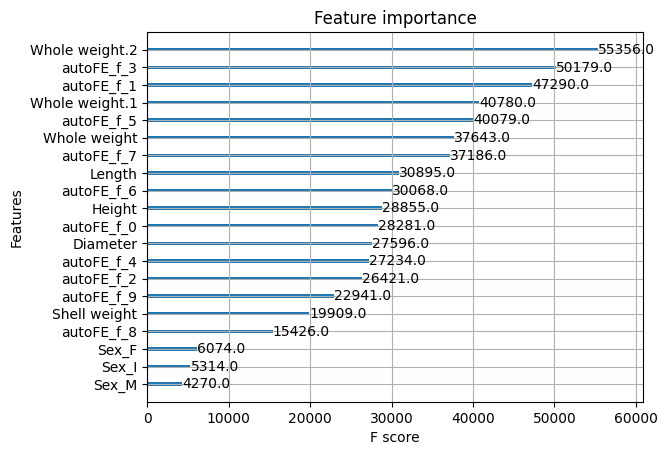

In [30]:
if Config.MODEL_TYPE == enums.ModelName.XGBoost:
    xgb.plot_importance(booster=fold_metrics_model[0][1])
elif Config.MODEL_TYPE == enums.ModelName.LGBM:
    lgbm.plot_importance(fold_metrics_model[0][1])

#### Prediction on test set

In [31]:
# For each fold, get the test predictions using corresponding fold model
df_fold_test_preds = tt.get_fold_test_preds(
                        fold_metrics_model,
                        df_test = df_test_onehot,
                        feature_cols = feature_cols,
                        num_folds = Config.NUM_FOLDS,
                    )
if Config.TRANSFORM_TARGET:
    # Since we have trained on np.log1p(y) instead of y, we need to reverse the transformation 
    # to extract the actual predictions. Thus we apply np.expm1 to each of the fold predictions.
    df_fold_test_preds = df_fold_test_preds.apply(np.expm1)
fold_metrics = [item[0] for item in fold_metrics_model]
# Since for RMSLE metric lower is better, we take the inverse of fold metric value to get its weight    
fold_weights = 1 / np.array(fold_metrics)
# normalize the fold weights
fold_weights = fold_weights / np.sum(fold_weights)
# Combine fold predictions using simple averaging    
df_fold_test_preds["test_preds"] = tt.combine_fold_test_preds(df_fold_test_preds, fold_weights=None)
print(f"Completed prediction for {len(df_test)} test rows")

Completed prediction for 60411 test rows


In [32]:
df_submission = pd.read_csv(SUBMISSION_FILEPATH + 'sample_submission.csv')
df_submission['Rings']= df_fold_test_preds["test_preds"]
df_submission.to_csv(DATA_WRITEPATH + f'submission_{Config.MODEL_TYPE}.csv',index=False)
df_fold_test_preds.to_csv(DATA_WRITEPATH + f'{Config.MODEL_TYPE}_test_preds.csv',index=False)
df_submission.head()

,id,Rings
0,90615,9.472968
1,90616,9.780221
2,90617,9.529883
3,90618,10.409288
4,90619,7.522636
